<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing-publication" data-toc-modified-id="Preprocessing-publication-1">Preprocessing publication</a></span><ul class="toc-item"><li><span><a href="#publication.csv-revisited" data-toc-modified-id="publication.csv-revisited-1.1"><code>publication.csv</code> revisited</a></span></li><li><span><a href="#Apply-standard-preprocessing:" data-toc-modified-id="Apply-standard-preprocessing:-1.2">Apply standard preprocessing:</a></span></li><li><span><a href="#Distribution-of-length-of-summary" data-toc-modified-id="Distribution-of-length-of-summary-1.3">Distribution of length of summary</a></span></li></ul></li></ul></div>

# Preprocessing publication 

In this notebook, I aim to detail the methods used for preprocessing the abstract and publications that will be part of the corpus used for topic modelling further down the pipeline.

Building on the dataset from the [preprocess-poinf.ipynb](../../../infnet-scrapper/notebooks/preprocess-poinf.ipynb), we further preprocess the additional details scrapped from Edinburgh research explorer. 

The main focus of [preprocess-poinf.ipynb](../../../infnet-scrapper/notebooks/preprocess-poinf.ipynb) is to preprocess the data collected from Edinburgh Research Explorer for . This notebook, on the other hand, focuses on the publications - the abstracts (if any) and publications/conferences that the research is presented in.

This is a precursor to a full-blown LDA analysis on the PDF of the research (the research papers).

## `publication.csv` revisited

I analyse the `publication.csv` dataset in this section.

In [1]:
import pandas as pd
import re

In [2]:
pub_csv = pd.read_csv('../data/publications.csv')
print 'pub_csv contains:', len(pub_csv), ' publications'
pub_csv.iloc[40:45]

pub_csv contains: 8810  publications


,pub_id,date,year,title,authors,pub_url,doi_url,pdf_url,abstract,publications
40,f4293dd4-09a5-420b-b37a-2bd88d45c6e6,1 Jun 2007,2007,statistical postediting on systrans rulebased ...,loïc dugast|jean senellart|philipp koehn,http://www.research.ed.ac.uk/portal/en/publica...,UNKNOWN,http://www.research.ed.ac.uk/portal/files/1936...,this article describes the combination of a sy...,proceedings of the second workshop on statisti...
41,fc393df2-bf68-45cd-85ce-9faeb2c9d9b4,17 May 2017,2017,endtoend deep learning of optimization heuristics,christopher cummins|pavlos petoumenos|zheng wa...,http://www.research.ed.ac.uk/portal/en/publica...,UNKNOWN,http://www.research.ed.ac.uk/portal/files/3774...,accurate automatic optimization heuristics are...,the 26th international conference on parallel ...
42,c7a7fc62-2251-441c-86ac-9e0a0a0d39c9,2016,2016,a list of successes that can change the world ...,sam lindley|conor mcbride|philip trinder|donal...,http://www.research.ed.ac.uk/portal/en/publica...,http://dx.doi.org/10.1007/978-3-319-30936-1,UNKNOWN,unknown,"springer international publishing,springer int..."
43,d7dbd219-5022-49c5-87d7-d6bafacfd3d8,2002,2002,a hierarchy of polynomialtime computable simul...,kousha etessami,http://www.research.ed.ac.uk/portal/en/publica...,http://dx.doi.org/10.1007/3-540-45694-5_10,UNKNOWN,we define and provide algorithms for computing...,"concur 2002 - concurrency theory,13th internat..."
44,8b81bb37-fced-4e23-a85d-ff82d715a2a0,2006,2006,computational modelling as an approach to neur...,jörg behrendt|hecke schrobsdorff|matthias ihrk...,http://www.research.ed.ac.uk/portal/en/publica...,UNKNOWN,http://www.nld.ds.mpg.de/~hecke/archiv/2006_BC...,negative priming (np),international journal of psychophysiology


In [3]:
pub_csv.set_index('pub_id',inplace=True)
pub_concise = pub_csv[['year', 'title', 'abstract', 'publications']].copy()

In [4]:
# Remove all entries that are 'UNKNOWN', so that when we combine them into the `summary` column, 
# `UNKNOWN` is not a term for consideration
def removeUnknown(x):
    if str(x).strip().lower() == 'unknown':
        return ''
    else:
        return x

In [5]:
pub_concise = pub_concise.applymap(removeUnknown)

In [6]:
# Concatenate all the text together to form as the representation of the publication:
pub_concise['summary'] = pub_concise.apply(
    lambda row: str(row.title) + ' ' + str(row.abstract) + ' '+  str(row.publications),
    axis=1)

## Apply standard preprocessing:

In [11]:
import Stemmer
import string

In [17]:
# Standard preprocessing:
# 1. tokenizer: split by word boundary.
tokenize = lambda x: [t.lower().strip() for t in re.split(r'\W+', x) if len(t) > 0]

# 2. stopping: import common stopwords
stopWordsDir = "../data/englishST.txt"
sw = open(stopWordsDir, "r").read().splitlines()
sw.extend(list(string.punctuation.decode('utf-8')))
stop = set(sw)
removeSW = lambda x: [t for t in x if t not in stop]

# 3: Stemming: using pystemmer
stemmer = Stemmer.Stemmer("english")
stem = lambda x : stemmer.stemWords(x)

In [14]:
preprocess = lambda x: stem(removeSW(tokenize(x)))

In [15]:
first = pub_concise.iloc[0].summary.decode('utf-8') + '~'

In [20]:
print " ".join(preprocess(first))

balloon stabil analysi jet hmode discharg previous studi stabil larg aspect ratio model equilibrium ideal mhd balloon mode shown bulk plasma exist margin stabl valu pressur gradient paramet defin unstabl zone separ small stabl region larg stabl region close separatrix region coalesc surfac averag current densiti exceed critic plasma region stabl balloon mode valu pressur gradient paper extend result jet mode equilibria finit aspect ratio balloon formal assess relev ideal balloon stabil discharg analys shot 15894 time 56 sec 1 3 phase proceed 16th european confer control fusion plasma physic


In [21]:
pub_concise['summary_toks'] = pub_concise.apply(lambda row: preprocess(row.summary.decode('utf8')), axis=1)

In [23]:
pub_concise.head(4)

,year,title,abstract,publications,summary,summary_toks
pub_id,,,,,,
400818dc-63af-4a26-80c5-906f98e1f8ab,1989,ballooning stability analysis of jet hmode dis...,previous studies of the stability of a large a...,proceedings 16th european conference on contr...,ballooning stability analysis of jet hmode dis...,"[balloon, stabil, analysi, jet, hmode, dischar..."
18b1a861-afef-4fff-bc80-d02e05be18c4,2013,query processing in data integration,in this chapter we illustrate the main techniq...,"data exchange, integration, and streams,dagstu...",query processing in data integration in this c...,"[queri, process, data, integr, chapter, illust..."
309fdbfc-227b-4588-9264-f0f4e3cadfcb,1994,comprehension syntax,the syntax of comprehensions is very close to ...,sigmod record,comprehension syntax the syntax of comprehensi...,"[comprehens, syntax, syntax, comprehens, close..."
d5814bab-5fc2-4c31-92b7-543c7ce75cb4,2012,evaluation of speaker verification security an...,"in this paper, we evaluate the vulnerability o...","ieee transactions on audio, speech and languag...",evaluation of speaker verification security an...,"[evalu, speaker, verif, secur, detect, hmmbase..."


## Distribution of length of summary

In [24]:
pub_toks = pub_concise[['summary_toks']].copy()

In [96]:
pub_toks.head(2)

,summary_toks
pub_id,
400818dc-63af-4a26-80c5-906f98e1f8ab,"[balloon, stabil, analysi, jet, hmode, dischar..."
18b1a861-afef-4fff-bc80-d02e05be18c4,"[queri, process, data, integr, chapter, illust..."


In [25]:
# inspect and check if there is any publication with no `summary_toks`
for row in pub_toks.iterrows():
    if len(row[1]['summary_toks']) == 0:
        print row[0]

In [26]:
# get a distribution of length of tokens:
toksLengthHist = {}
for row in pub_toks.iterrows():
    l = len(row[1]['summary_toks'])
    if l not in toksLengthHist.keys():
        toksLengthHist[l] = 1
    else:
        toksLengthHist[l] += 1

In [27]:
lengthHist = [(v,k) for (v,k) in toksLengthHist.iteritems()]

In [28]:
print lengthHist

[(1, 1), (2, 4), (3, 14), (4, 26), (5, 55), (6, 62), (7, 83), (8, 105), (9, 84), (10, 98), (11, 97), (12, 88), (13, 83), (14, 57), (15, 66), (16, 58), (17, 51), (18, 44), (19, 44), (20, 40), (21, 41), (22, 41), (23, 34), (24, 38), (25, 33), (26, 35), (27, 27), (28, 36), (29, 29), (30, 38), (31, 33), (32, 24), (33, 38), (34, 38), (35, 30), (36, 33), (37, 30), (38, 38), (39, 42), (40, 53), (41, 39), (42, 49), (43, 40), (44, 44), (45, 36), (46, 42), (47, 55), (48, 61), (49, 68), (50, 77), (51, 71), (52, 60), (53, 52), (54, 70), (55, 69), (56, 79), (57, 76), (58, 78), (59, 81), (60, 73), (61, 79), (62, 72), (63, 84), (64, 76), (65, 89), (66, 73), (67, 90), (68, 77), (69, 84), (70, 83), (71, 104), (72, 100), (73, 85), (74, 82), (75, 91), (76, 109), (77, 84), (78, 91), (79, 106), (80, 89), (81, 92), (82, 105), (83, 89), (84, 89), (85, 84), (86, 85), (87, 93), (88, 85), (89, 83), (90, 90), (91, 83), (92, 66), (93, 77), (94, 82), (95, 83), (96, 76), (97, 80), (98, 80), (99, 70), (100, 81), (10

In [37]:
# Visualise:
%matplotlib inline
import seaborn as sns

In [40]:
lengths = zip(*lengthHist)[0]
freq = zip(*lengthHist)[1]

In [53]:
import numpy as np

In [83]:
data = [list(lengths), list(freq)]
pd_data = pd.DataFrame(np.array(data).T, columns=['length','count'])

In [85]:
pd_data.head(5)

,length,count
0,1,1
1,2,4
2,3,14
3,4,26
4,5,55


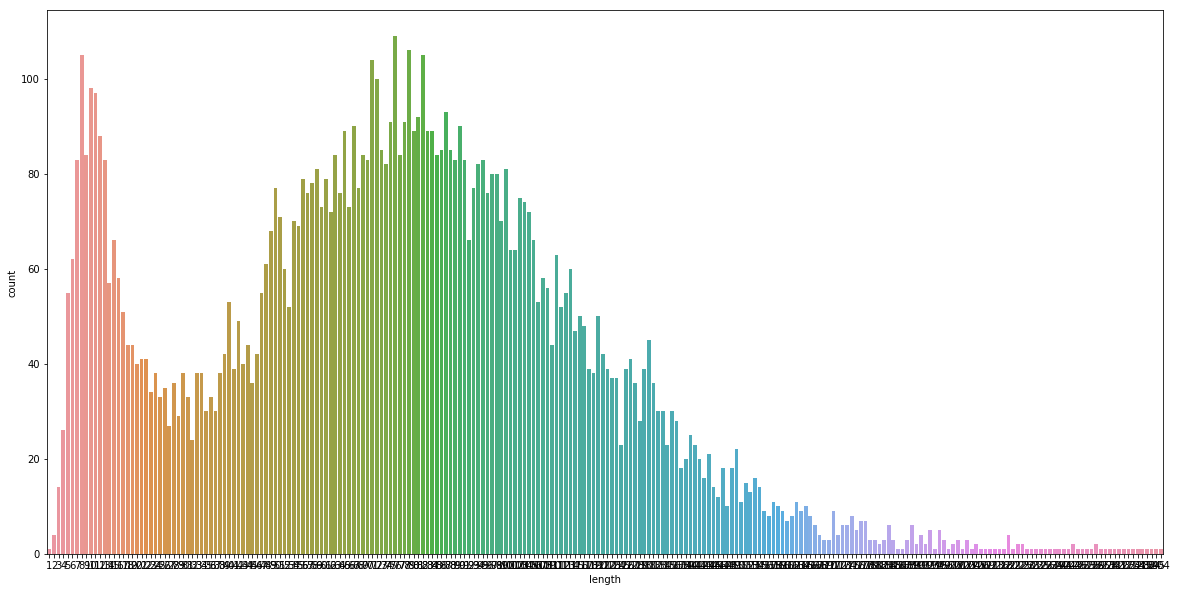

In [95]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
sns.barplot(x='length', y='count', data=pd_data, ax=ax)

In [97]:
pub_concise.to_pickle('../data/pub_toks.pkl')